In [154]:
import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame

df = pd.read_csv("processed_dataset.csv")
df.columns

Index(['Unnamed: 0', 'PassengerId', 'Survived', 'SibSp', 'Parch', 'Cabin_No',
       'Cabin_Yes', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_scaled',
       'Fare_scaled'],
      dtype='object')

### Logistic Regression

我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模。

regex : string (regular expression)

Keep info axis with re.search(regex, col) == True

https://pandas.pydata.org/pandas-docs/version/0.21.0/generated/pandas.DataFrame.filter.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [155]:
from sklearn import linear_model
# Age_.* means any fields begin with Age
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)  
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

### Logistic Regression prediction on test dataset

In [156]:
df_test = pd.read_csv("processed_test_dataset.csv")
df_test.columns

Index(['Unnamed: 0', 'PassengerId', 'SibSp', 'Parch', 'Cabin_No', 'Cabin_Yes',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_scaled', 'Fare_scaled'],
      dtype='object')

In [157]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [158]:
#result.to_csv("logistic_regression_predictions.csv", index=False)

### Logistic Regression prediction accuracy:77.511%

### heatmap

https://www.kaggle.com/vankhoa21991/titanic-svm-prediction-kl

### Model Optimization

In [159]:
pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

,columns,coef
0,SibSp,[-0.3442356443899657]
1,Parch,[-0.10491610800430981]
2,Cabin_No,[-0.06980216471243221]
3,Cabin_Yes,[0.8323058518357968]
4,Embarked_C,[0.0]
5,Embarked_Q,[0.0]
6,Embarked_S,[-0.4172647199093915]
7,Sex_female,[2.0263749597585052]
8,Sex_male,[-0.6076165906359808]
9,Pclass_1,[0.3411581550059858]


### Cross Validation

In [160]:
from sklearn import cross_validation

 #简单看看打分情况
#clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
#all_data = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
#x = all_data.values[:,1:]
#y = all_data.values[:,0]
scores = cross_validation.cross_val_score(clf,x,y,scoring='accuracy', cv=5)
print (scores)

[0.81564246 0.81564246 0.78651685 0.78651685 0.81355932]


### bad case in Cross Validation

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [81]:
# 分割数据，按照 训练数据:cv数据 = 7:3的比例
split_train, split_cv = cross_validation.train_test_split(df, test_size=0.3, random_state=0)
train_df = split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# 生成模型
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(train_df.values[:,1:], train_df.values[:,0])

# 对cross validation数据进行预测

cv_df = split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(cv_df.values[:,1:])

origin_data_train = pd.read_csv("processed_dataset.csv")
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.values[:,0]]['PassengerId'].values)]
bad_cases.shape
# the number of bad cases is the same as in original data (both 50)
### need further consider

(50, 17)

In [82]:
bad_cases.head()

,Unnamed: 0,PassengerId,Survived,SibSp,Parch,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
14,14,15,0,0,0,1,0,0,0,1,1,0,0,0,1,-1.148655,-0.490280
49,49,50,0,1,0,1,0,0,0,1,1,0,0,0,1,-0.855018,-0.290024
55,55,56,1,0,0,0,1,0,0,1,0,1,1,0,0,1.058386,0.066360
65,65,66,1,1,1,1,0,1,0,0,0,1,0,0,1,-0.921092,-0.341452
68,68,69,1,4,2,1,0,0,0,1,1,0,0,0,1,-0.928427,-0.488854


can try Survived~C(Pclass)+C(Title)+C(Sex)+C(Age_bucket)+C(Cabin_num_bucket)Mother+Fare+Family_Size

In [122]:
data_train = pd.read_csv("train.csv")
data_train['Sex_Pclass'] = data_train.Sex + "_" + data_train.Pclass.map(str)
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Pclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male_3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female_1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female_3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female_1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male_3


from sklearn.ensemble import RandomForestRegressor
from age_cabin_process import *
#from imp import reload
#reload(set_missing_ages)
#reload(set_Cabin_type)

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

In [123]:
from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].values
    unknown_age = age_df[age_df.Age.isnull()].values

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

# One-hot
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')
dummies_Sex_Pclass = pd.get_dummies(data_train['Sex_Pclass'], prefix= 'Sex_Pclass')

#Contact
df = pd.concat([data_train,dummies_Cabin,dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Sex_Pclass'], axis=1, inplace=True)

# Scale
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
                                
age_scale_param = scaler.fit(df[['Age']])
df['Age_scaled'] = scaler.fit_transform(df[['Age']], age_scale_param)
fare_scale_param = scaler.fit(df[['Fare']])
df['Fare_scaled'] = scaler.fit_transform(df[['Fare']], fare_scale_param)

df.drop(['Age','Fare'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,SibSp,Parch,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,...,Pclass_2,Pclass_3,Sex_Pclass_female_1,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3,Age_scaled,Fare_scaled
0,1,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,-0.561380,-0.502445
1,2,1,1,0,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,0.613171,0.786845
2,3,1,0,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,0,-0.267742,-0.488854
3,4,1,1,0,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0.392942,0.420730
4,5,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0.392942,-0.486337


In [124]:
df.shape

(891, 22)

In [125]:
from sklearn import linear_model

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

### Same process on test data

In [126]:
data_test = pd.read_csv("test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
data_test['Sex_Pclass'] = data_test.Sex + "_" + data_test.Pclass.map(str)
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].values
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges
data_test = set_Cabin_type(data_test)

# one hot
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')
dummies_Sex_Pclass = pd.get_dummies(data_test['Sex_Pclass'], prefix= 'Sex_Pclass')

df_test = pd.concat([data_test,dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Sex_Pclass'], axis=1, inplace=True)

# scale
df_test['Age_scaled'] = scaler.fit_transform(df_test[['Age']], age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test[['Fare']], fare_scale_param)
df_test.drop(['Age','Fare'], axis=1, inplace=True)
df_test.head()

,PassengerId,SibSp,Parch,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,...,Pclass_2,Pclass_3,Sex_Pclass_female_1,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3,Age_scaled,Fare_scaled
0,892,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0.307521,-0.496637
1,893,1,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1.256241,-0.511497
2,894,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,2.394706,-0.463335
3,895,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,-0.261711,-0.481704
4,896,1,1,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,-0.641199,-0.416740


In [127]:
df_test.shape

(418, 21)

In [129]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions2.csv", index=False)

### 77.511%

### fitting

'''
    
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
  '''

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

http://scikit-learn.org/stable/modules/learning_curve.html

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.gca.html

https://stackoverflow.com/questions/2051744/reverse-y-axis-in-pyplot

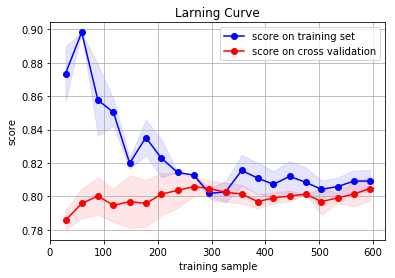

(0.8065696844854024, 0.018258876711338634)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
   
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"training sample")
        plt.ylabel(u"score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"score on training set")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"score on cross validation")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff
plot_learning_curve(clf, u"Larning Curve", X, y)

在实际数据上看，我们得到的learning curve没有理论推导的那么光滑哈，但是可以大致看出来，训练集和交叉验证集上的得分曲线走势还是符合预期的。

目前的曲线看来，我们的model并不处于overfitting的状态(overfitting的表现一般是训练集上得分高，而交叉验证集上要低很多，中间的gap比较大)。因此我们可以再做些feature engineering的工作，添加一些新产出的特征或者组合特征到模型中。

and can try more advanced SGD algorithm later

### Model Ensemble

模型融合可以比较好地缓解，训练过程中产生的过拟合问题，从而对于结果的准确度提升有一定的帮助

### Model Ensemble 1.1 Bagging

In [67]:
from sklearn.ensemble import BaggingRegressor

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title')
predictions = bagging_clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_bagging_predictions.csv", index=False)

### the result is 77.511%
### drop passanger ID may improve.

###  Model Ensemble 1.2 Random Forest

In [139]:
train_df = pd.read_csv("processed_dataset.csv")
train_df.drop("PassengerId", axis=1, inplace=True)

In [162]:
# Age_.* means any fields begin with Age
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
forest = RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                max_depth=5,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                random_state=0)
forest.fit(X, y)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [163]:
### cross validation

In [167]:
scores = cross_validation.cross_val_score(forest,x,y,scoring='accuracy',cv=5)
scores

array([0.81564246, 0.80446927, 0.80898876, 0.80337079, 0.81355932])

### Model Ensemble 1.3 SVM

https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm
    # 值得学习！！！
    小提琴图； 年龄分类（can be used to child and mother）

In [170]:
from sklearn.svm import SVC
train_df = pd.read_csv("processed_dataset.csv")
train_df.drop("PassengerId", axis=1, inplace=True)
# Age_.* means any fields begin with Age
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
svm = SVC()
svm.fit(X, y)
svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [178]:
scores = cross_validation.cross_val_score(svm,x,y,scoring='accuracy',cv=5)
scores

array([0.82681564, 0.82122905, 0.81460674, 0.80898876, 0.84180791])

### Model Ensemble 1.4 More models

https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm

In [186]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, plot_importance 
from xgboost import XGBRegressor

In [177]:
train_df = pd.read_csv("processed_dataset.csv")
train_df.drop("PassengerId", axis=1, inplace=True)
# Age_.* means any fields begin with Age
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

In [189]:
import warnings
warnings.filterwarnings('ignore')

clf_rf = RandomForestClassifier()
clf_et = ExtraTreesClassifier()
clf_bc = BaggingClassifier()
clf_ada = AdaBoostClassifier()
clf_dt = DecisionTreeClassifier()
clf_xg = XGBClassifier()
clf_lr = LogisticRegression()
clf_svm = SVC()

scores = []
models = [clf_rf, clf_et, clf_bc, clf_ada, clf_dt, clf_xg, clf_lr, clf_svm]
for model in models:
    score = cross_val_score(model, x, y, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
    scores.append(score)
    
Classifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','XGBoost','LogisticRegression','SVM']
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)
mode

,score
XGBoost,0.826101
SVM,0.824927
AdaBoost,0.816064
RandomForest,0.814902
LogisticRegression,0.804715
Bagging,0.803654
ExtraTrees,0.798073
DecisionTree,0.772318


### Model Ensemble 1.5 Ensemble Modeling

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    
    !!!!
    outlier detection
    敲多可视化分析，matplotlib best
    Age column contains 256 missing values in the whole dataset.
    decided to use SibSP, Parch and Pclass in order to impute the missing ages.
    还有超级多的model 还能画出图来
    

### 1.6 Hyperparameter tunning for best models

performed a grid search optimization for XGBoost, SVM , AdaBoost, RandomForest classifiers.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [197]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

https://blog.csdn.net/wzmsltw/article/details/50994481

In [208]:
# XGBoost
clf =XGBClassifier(learning_rate=0.1, max_depth=2, 
silent=True, objective='binary:logistic')
# 设置boosting迭代计算次数
param_test = {
    'n_estimators': range(30, 50, 2),
    'max_depth': range(2, 7, 1)
}
grid_search = GridSearchCV(estimator = clf, param_grid = param_test, 
scoring='accuracy', cv=5)
grid_search.fit(x,y)
#grid_search.grid_scores_,
grid_search.best_params_,grid_search.best_score_

({'max_depth': 6, 'n_estimators': 38}, 0.8361391694725028)

In [209]:
XGB = XGBClassifier(learning_rate=0.1)
# 设置boosting迭代计算次数
XGB_param_grid = {'n_estimators': range(30, 50, 2),
                  'max_depth': range(2, 7, 1)}
gsXGB = GridSearchCV(XGB,param_grid = XGB_param_grid,cv=kfold, scoring="accuracy", n_jobs= -1,verbose = 1)
gsXGB.fit(x,y)
XGB_best = gsXGB.best_estimator_
# Best score
gsXGB.best_score_

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.3s finished


0.8338945005611672

In [200]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(x,y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   39.0s finished


0.8305274971941639

https://www.cnblogs.com/pinard/p/6136914.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [199]:
#RandomForest
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(x,y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


0.8294051627384961

https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm
    多个模型调参数的循环算法

### 1.5.1 Feature importance of tree based classifiers

In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

import seaborn as sns
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("XGBClassifier", XGB_best),("SVM",SVMC_best),("RandomForest",RFC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=x.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

### 1.5.2 Ensemble Model - Combining Model

In [250]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[("XGBClassifier", XGB_best),("SVM",SVMC_best),("RandomForest",RFC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(x, y)

In [252]:
scores = cross_validation.cross_val_score(votingC,x,y,scoring='accuracy', cv=10)
print (scores)

[0.77777778 0.82222222 0.74157303 0.88764045 0.92134831 0.82022472
 0.83146067 0.76404494 0.86516854 0.875     ]


### Model Stacking

https://zhuanlan.zhihu.com/p/25836678